In [14]:
import math
import numpy as np
import scipy as sp
from scipy.linalg import eig
from numpy import sin, cos, abs, exp, sqrt, arccos, pi

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

1 / 1
1 / 1


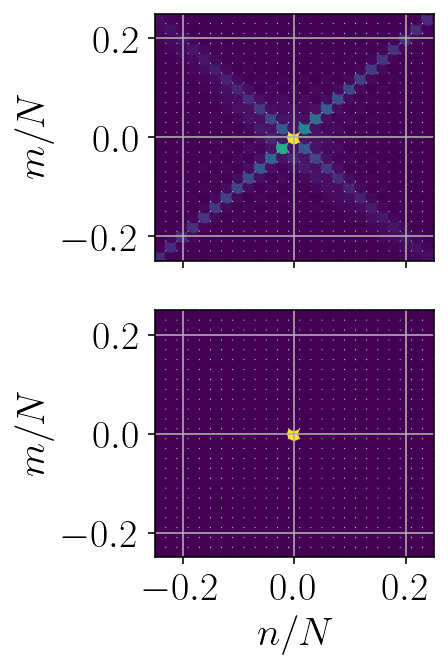

In [15]:
indices = [0, 1]

plt.rcParams["figure.figsize"] = [2.5, 5]
fig, ax = plt.subplots(2, 1)
fs = 20
width = 0.25

from matplotlib import cm

for index in indices:

    U_list = [0.0] # Kerr non-linearity
    gamma = 5e-2 # Loss rate
    J = 1.0 # Tunneling
    N = 50 # Number of cavities in the vertical direction
    M = 50 # Number of cavities in the horizontal direction
    # Pump
    F = np.zeros((N, M), dtype=np.complex128)
    if index == 0:
        F[int(N/2), int(M/2)] = 1.0 # Central pump
    else:
        # Localization
        F[int(N/2), int(M/2-1)] = 1.0
        F[int(N/2-1), int(M/2)] = 1.0
        F[int(N/2), int(M/2+1)] = 1.0
        F[int(N/2+1), int(M/2)] = 1.0

    Delta_list = [0.0] # np.linspace(0.0, 2.0, 50)

    T = np.zeros((N, M, N, M), dtype=np.float64)

    for j in range(N):
        for k in range(M-1):

            T[j, k+1, j, k] = -J
            T[j, k, j, k+1] = -J

    for j in range(N-1):
        for k in range(M):

            T[j+1, k, j, k] = -J
            T[j, k, j+1, k] = -J

    def f_RK4(Delta, U, gamma, F, a):

        y = -1.0j * (
            -Delta*a + U*abs(a)**2*a + np.einsum('nmjk,jk->nm', T, a) - 1.0j*gamma*a + F
        )
        
        return y

    N_t = 1e3 # Number of time steps
    t_f = 1e2 # Final time
    t = np.linspace(0, t_f, int(N_t))
    Delta_t = t[1] - t[0]

    a_list = []
    ll_list = []

    # Cavity fields
    a = np.zeros((N, M, int(N_t)), dtype=np.complex128)

    count = 0

    for U, Delta in zip(U_list, Delta_list):

        print('{:} / {:}'.format(count+1, len(U_list)))

        for i_t in range(len(t)-1):

            k1 = f_RK4(Delta, U, gamma, F, a[:, :, i_t])
            k2 = f_RK4(Delta, U, gamma, F, a[:, :, i_t] + k1*Delta_t/2)
            k3 = f_RK4(Delta, U, gamma, F, a[:, :, i_t] + k2*Delta_t/2)
            k4 = f_RK4(Delta, U, gamma, F, a[:, :, i_t] + k3*Delta_t)

            a[:, :, i_t+1] = a[:, :, i_t] + (k1 + 2*k2 + 2*k3 + k4)*Delta_t/6

        a[:, :, 0] = a[:, :, -1]
        a_list.append(np.array(a[:, :, -1]))

        ll = np.abs(a[int(N/2), int(M/2), -1])**2 / np.sum(np.abs(a[:, :, -1])**2)
        ll_list.append(ll)
        
        count += 1

    a_list = np.array(a_list)

    x = np.linspace(0, M-1, M)
    y = np.linspace(0, N-1, N)
    X, Y = np.meshgrid(x, y)

    cp = ax[index].scatter(X/M-0.5, Y/N-0.5, c=abs(a_list[0])**2)

    # Full lattice limits
    ax[index].set_xlim([-0.25, 0.25])
    ax[index].set_ylim([-0.25, 0.25])
    ax[index].set_yticks([-0.2, 0.0, 0.2])

    ax[index].set_ylabel(r'$m/N$',fontsize=fs)

    ax[index].tick_params(axis='both', labelsize=fs)
ax[0].set_xticks([-0.2, 0.0, 0.2])
ax[0].set_xticklabels([])    
ax[1].set_xticks([-0.2, 0.0, 0.2])
ax[1].set_xlabel(r'$n/N$',fontsize=fs)
ax[0].grid()
ax[1].grid()